In [1]:
!pip install --q lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 11.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
data = [
    ("P001", "leased",      "2018-01-01", "2020-02-28"),
    ("P001", "maintenance", "2020-03-01", "2020-05-01"),
    ("P001", "listed",      "2020-05-02", "2020-06-15"),
    ("P001", "leased",      "2020-06-16", "2022-05-31"),
    ("P001", "listed",      "2022-06-01", "2022-08-01"),
    ("P001", "leased",      "2022-08-02", "2024-09-01"),
    ("P001", "maintenance", "2024-09-02", "2024-11-01"),
    ("P001", "listed",      "2024-11-02", "2024-12-31"),

    ("P002", "leased",      "2019-02-01", "2021-03-31"),
    ("P002", "listed",      "2021-04-01", "2021-06-30"),
    ("P002", "leased",      "2021-07-01", "2023-01-31"),
    ("P002", "listed",      "2023-02-01", "2023-07-01"),
    ("P002", "maintenance", "2023-07-02", "2023-08-01"),
    ("P002", "listed",      "2023-08-02", "2023-09-15"),
    ("P002", "leased",      "2023-09-16", "2024-12-31"),

    ("P003", "leased",      "2020-05-01", "2021-12-31"),
    ("P003", "listed",      "2022-01-01", "2022-03-15"),
    ("P003", "leased",      "2022-03-16", "2024-09-30"),
    ("P003", "maintenance", "2024-10-01", "2024-11-30"),
    ("P003", "listed",      "2024-12-01", "2024-12-31"),
]
statuses = pd.DataFrame(data, columns=["property_id","status","start_date","end_date"])
statuses["start_date"] = pd.to_datetime(statuses["start_date"])
statuses["end_date"]   = pd.to_datetime(statuses["end_date"])
statuses.head()

,property_id,status,start_date,end_date
0,P001,leased,2018-01-01,2020-02-28
1,P001,maintenance,2020-03-01,2020-05-01
2,P001,listed,2020-05-02,2020-06-15
3,P001,leased,2020-06-16,2022-05-31
4,P001,listed,2022-06-01,2022-08-01


In [12]:
# generate spells (events where the property is listed and number of days)

AT_RISK = {"listed"}
LEASED  = "leased"

records = []
for pid, g in statuses.groupby("property_id", sort=False):
    g = g.sort_values("start_date").reset_index(drop=True)
    for i, row in g.iterrows():
        if row["status"] in AT_RISK:
            spell_start = row["start_date"]
            if i+1 < len(g):
                next_row = g.loc[i+1]
                spell_end = next_row["start_date"]
                event = 1 if next_row["status"] == LEASED else 0
            else:
                spell_end = row["end_date"]  # censor at end of last known segment
                event = 0
            duration = (spell_end - spell_start).days
            records.append({
                "property_id": pid,
                "spell_start": spell_start,
                "spell_end": spell_end,
                "duration": duration,
                "event": event
            })

spells = pd.DataFrame(records)

spells.head()

,property_id,spell_start,spell_end,duration,event
0,P001,2020-05-02,2020-06-16,45,1
1,P001,2022-06-01,2022-08-02,62,1
2,P001,2024-11-02,2024-12-31,59,0
3,P002,2021-04-01,2021-07-01,91,1
4,P002,2023-02-01,2023-07-02,151,0


In [21]:
# add dummy covariates

np.random.seed(7)
spells["market_vacancy_rate"] = np.random.uniform(0.05, 0.12, len(spells))

# Assign a single random unit_size_sqft to each property_id
unique_property_ids = spells["property_id"].unique()
unit_sizes = np.random.randint(700, 1500, len(unique_property_ids))
unit_size_map = dict(zip(unique_property_ids, unit_sizes))

spells["unit_size_sqft"] = spells["property_id"].map(unit_size_map)

# Modify asking_rent to start with a random value and increase by 2-5% for each subsequent row of the same property_id
def update_asking_rent(group):
    group = group.sort_values("spell_start")
    initial_rent = np.random.normal(2500, 300)
    rents = [initial_rent]
    for _ in range(1, len(group)):
        increase_percentage = np.random.uniform(1.02, 1.05)
        next_rent = rents[-1] * increase_percentage
        rents.append(next_rent)
    group["asking_rent"] = np.round(rents).astype(int)
    return group

spells = spells.groupby("property_id").apply(update_asking_rent).reset_index(drop=True)

/tmp/ipython-input-4074060742.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spells = spells.groupby("property_id").apply(update_asking_rent).reset_index(drop=True)


In [22]:
spells

,property_id,spell_start,spell_end,duration,event,asking_rent,unit_size_sqft,market_vacancy_rate
0,P001,2020-05-02,2020-06-16,45,1,2386,1430,0.055342
1,P001,2022-06-01,2022-08-02,62,1,2462,1430,0.104594
2,P001,2024-11-02,2024-12-31,59,0,2561,1430,0.080689
3,P002,2021-04-01,2021-07-01,91,1,2749,867,0.100643
4,P002,2023-02-01,2023-07-02,151,0,2860,867,0.118459
5,P002,2023-08-02,2023-09-16,45,1,2976,867,0.087695
6,P003,2022-01-01,2022-03-16,74,1,2671,768,0.085078
7,P003,2024-12-01,2024-12-31,30,0,2745,768,0.055044


In [24]:
# Train/validation split

cutoff = pd.Timestamp("2023-01-01")
train = spells[spells["spell_start"] < cutoff].copy()
valid = spells[spells["spell_start"] >= cutoff].copy()

In [25]:
train.head()

,property_id,spell_start,spell_end,duration,event,asking_rent,unit_size_sqft,market_vacancy_rate
0,P001,2020-05-02,2020-06-16,45,1,2386,1430,0.055342
1,P001,2022-06-01,2022-08-02,62,1,2462,1430,0.104594
3,P002,2021-04-01,2021-07-01,91,1,2749,867,0.100643
6,P003,2022-01-01,2022-03-16,74,1,2671,768,0.085078


In [27]:
# Fit CoxPH model

cph = CoxPHFitter()
cph.fit(
    train.drop(columns=["spell_start", "spell_end"]),
    duration_col="duration",
    event_col="event",
    cluster_col="property_id",
    show_progress=True
)

print("CoxPH Summary (train)")
cph.print_summary()

Iteration 1: norm_delta = 1.55e+00, step_size = 0.9500, log_lik = -3.17805, newton_decrement = 2.30e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.13e+00, step_size = 0.9500, log_lik = -0.79664, newton_decrement = 4.02e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.89e+00, step_size = 0.9500, log_lik = -0.30524, newton_decrement = 1.52e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.82e+00, step_size = 0.9310, log_lik = -0.12134, newton_decrement = 6.04e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.80e+00, step_size = 1.0000, log_lik = -0.04489, newton_decrement = 2.24e-02, seconds_since_start = 0.0
Iteration 6: norm_delta = 1.79e+00, step_size = 1.0000, log_lik = -0.01655, newton_decrement = 8.27e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 1.79e+00, step_size = 1.0000, log_lik = -0.00609, newton_decrement = 3.05e-03, seconds_since_start = 0.0
Iteration 8: norm_delta = 1.79e+00, step_size = 1.0000, log_lik = -0.00224, newton_

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1589: ConvergenceWarning: The log-likelihood is getting suspiciously close to 0 and the delta is still large. There may be complete separation in the dataset. This may result in incorrect inference of coefficients. See https://stats.stackexchange.com/q/11109/11867 for more.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column asking_rent has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://

<lifelines.CoxPHFitter: fitted with 4 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
              cluster col = 'property_id'
          robust variance = True
      baseline estimation = breslow
   number of observations = 4
number of events observed = 4
   partial log-likelihood = -0.00
         time fit was run = 2025-11-10 07:48:18 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
asking_rent          -0.10      0.90      0.01           -0.13           -0.08                0.88                0.92
unit_size_sqft       -0.01      0.99      0.00           -0.02           -0.01                0.98                0.99
market_vacancy_rate -85.81      0.00     30.22         -145.04          -26.58                0.00                0.00

                     cmp to     z      p  -log2(p)
covariate                                         
asking_rent            0.00 -8.99 <0.005     61.82
unit_size_sqft         0.00 -3.12 <0.005      9.11
market_vacancy_rate    0.00 -2.84 <0.005      7.79
---
Concordance = 1.00
Partial AIC = 6.00
log-likelihood ratio test = 6.36 on 3 df
-log2(p) of ll-ratio test = 3.39

In [28]:
# Concordance index on training

print(f"Train C-index: {cph.concordance_index_:.3f}")

Train C-index: 1.000


In [29]:
# On validation: use negative partial hazard as "predicted time" proxy (higher risk -> shorter duration)

if len(valid) > 0:
    risk_valid = -cph.predict_partial_hazard(valid)  # negative so higher = longer time; matches concordance API
    cval = concordance_index(valid["duration"], risk_valid.values.ravel(), valid["event"])
    print(f"Valid C-index: {cval:.3f}")
else:
    print("No validation rows in this small example split.")

Valid C-index: 0.000


In [30]:
# Predict leasing probabilities by horizon (30/60/90 days)

target_df = valid if len(valid) > 0 else train.copy()
target_df

,property_id,spell_start,spell_end,duration,event,asking_rent,unit_size_sqft,market_vacancy_rate
2,P001,2024-11-02,2024-12-31,59,0,2561,1430,0.080689
4,P002,2023-02-01,2023-07-02,151,0,2860,867,0.118459
5,P002,2023-08-02,2023-09-16,45,1,2976,867,0.087695
7,P003,2024-12-01,2024-12-31,30,0,2745,768,0.055044


In [32]:
# Predict leasing probabilities by horizon (30/60/90 days)

target_df = valid if len(valid) > 0 else train.copy()

# Predict survival function at specific times
prediction_times = [30, 60, 90]
S = cph.predict_survival_function(target_df, times=prediction_times)  # rows=time, cols=rows of target_df

for t in prediction_times:
    target_df[f"P_leased_{t}d"] = 1 - S.loc[t].values

display(target_df)

,property_id,spell_start,spell_end,duration,event,asking_rent,unit_size_sqft,market_vacancy_rate,P_leased_30d,P_leased_60d,P_leased_90d
2,P001,2024-11-02,2024-12-31,59,0,2561,1430,0.080689,1.295728e-09,2.203287e-04,1.000000e+00
4,P002,2023-02-01,2023-07-02,151,0,2860,867,0.118459,0.000000e+00,5.551115e-16,1.869188e-06
5,P002,2023-08-02,2023-09-16,45,1,2976,867,0.087695,0.000000e+00,0.000000e+00,1.422813e-10
7,P003,2024-12-01,2024-12-31,30,0,2745,768,0.055044,4.977130e-13,8.463316e-08,1.000000e+00


In [33]:
print("Example predictions (probability leased within 30/60/90 days)")
cols_show = ["property_id","duration","event","asking_rent","unit_size_sqft","market_vacancy_rate",
             "P_leased_30d","P_leased_60d","P_leased_90d"]
print(target_df[cols_show].to_string(index=False))

Example predictions (probability leased within 30/60/90 days)
property_id  duration  event  asking_rent  unit_size_sqft  market_vacancy_rate  P_leased_30d  P_leased_60d  P_leased_90d
       P001        59      0         2561            1430             0.080689  1.295728e-09  2.203287e-04  1.000000e+00
       P002       151      0         2860             867             0.118459  0.000000e+00  5.551115e-16  1.869188e-06
       P002        45      1         2976             867             0.087695  0.000000e+00  0.000000e+00  1.422813e-10
       P003        30      0         2745             768             0.055044  4.977130e-13  8.463316e-08  1.000000e+00



=== Calibration (90d) by prediction bucket ===
   bucket  predicted_mean  observed_km  n
0       0    1.422813e-10          1.0  1
1       1    1.869188e-06          0.0  1
2       2    1.000000e+00          0.0  2


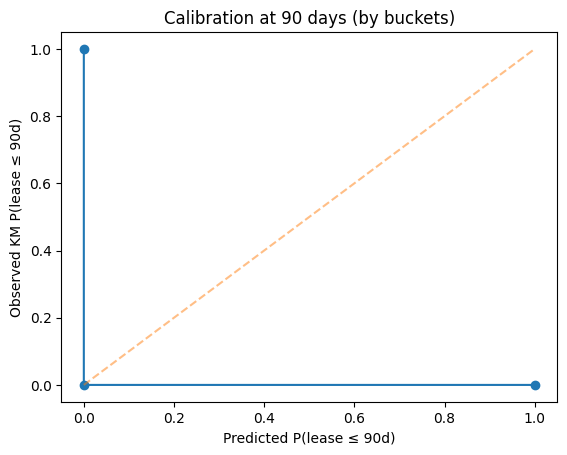

In [34]:
if len(target_df) >= 4:
    t_cal = 90
    # predicted prob of event by t
    pred_p = target_df["P_leased_90d"].values

    # bucket into quartiles (for small data; use deciles for big data)
    q = pd.qcut(pred_p, q=4, labels=False, duplicates="drop")
    target_df = target_df.assign(bucket=q)

    # compute empirical event prob by t using Kaplan–Meier within each bucket:
    # P(event by t) = 1 - S_KM(t)
    rows = []
    for b, grp in target_df.groupby("bucket"):
        kmf = KaplanMeierFitter()
        kmf.fit(durations=grp["duration"], event_observed=grp["event"])
        # KM survival at t_cal; clip t to observed max index
        S_t = float(kmf.survival_function_at_times(t_cal).values.squeeze())
        obs_p = 1 - S_t
        pred_mean = float(grp["P_leased_90d"].mean())
        rows.append({"bucket": int(b), "predicted_mean": pred_mean, "observed_km": obs_p, "n": len(grp)})
    calib = pd.DataFrame(rows).sort_values("bucket")
    print("\n=== Calibration (90d) by prediction bucket ===")
    print(calib)

    # Optional quick plot
    try:
        plt.figure()
        plt.plot(calib["predicted_mean"], calib["observed_km"], marker="o")
        plt.plot([0,1],[0,1],"--",alpha=0.5)
        plt.xlabel("Predicted P(lease ≤ 90d)")
        plt.ylabel("Observed KM P(lease ≤ 90d)")
        plt.title("Calibration at 90 days (by buckets)")
        plt.show()
    except Exception as e:
        print("Plotting skipped:", e)
else:
    print("\nNot enough rows to do a bucketed calibration example; add more data for a better check.")